Generation 0: Avg Fitness = 2.477
Generation 50: Avg Fitness = 8.969
Generation 100: Avg Fitness = 9.373
Generation 150: Avg Fitness = 9.403
Generation 200: Avg Fitness = 8.919
Generation 250: Avg Fitness = 9.562
Generation 300: Avg Fitness = 9.512
Generation 350: Avg Fitness = 9.499
Generation 400: Avg Fitness = 9.080
Generation 450: Avg Fitness = 9.198
Generation 500: Avg Fitness = 9.548
Generation 550: Avg Fitness = 9.411
Generation 600: Avg Fitness = 9.356
Generation 650: Avg Fitness = 9.358
Generation 700: Avg Fitness = 9.206
Generation 750: Avg Fitness = 9.613
Generation 800: Avg Fitness = 9.400
Generation 850: Avg Fitness = 9.000
Generation 900: Avg Fitness = 9.458
Generation 950: Avg Fitness = 9.429
Generation 1000: Avg Fitness = 9.190
Generation 1050: Avg Fitness = 9.404
Generation 1100: Avg Fitness = 9.574
Generation 1150: Avg Fitness = 9.534
Generation 1200: Avg Fitness = 9.251
Generation 1250: Avg Fitness = 9.479
Generation 1300: Avg Fitness = 9.568
Generation 1350: Avg Fit

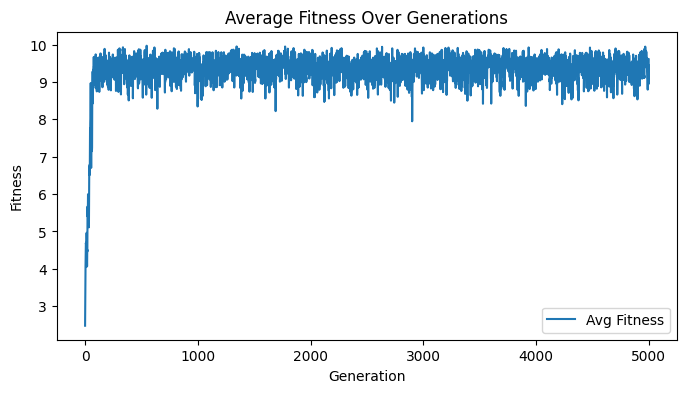


Phylogenetic Tree Summary (parent lineage_id -> number of children):
988211 -> 146 children
861723 -> 3 children
256703 -> 9 children
229975 -> 74 children
48051 -> 7 children
638721 -> 7 children
229259 -> 38 children
869694 -> 13 children
263627 -> 17 children
679515 -> 997881 children
732053 -> 4 children
517489 -> 5 children
787353 -> 2 children
105908 -> 28 children
625381 -> 5 children
795668 -> 35 children
848750 -> 1 children
927658 -> 10 children
902932 -> 192 children
523482 -> 1 children
665823 -> 56 children
33327 -> 1 children
562276 -> 54 children
648565 -> 2 children
307420 -> 2 children
752788 -> 5 children
941436 -> 4 children
666564 -> 6 children
713537 -> 4 children
475436 -> 2 children
275505 -> 19 children
674080 -> 2 children
145052 -> 3 children
657925 -> 19 children
738798 -> 10 children
279947 -> 12 children
45562 -> 10 children
201630 -> 6 children
234054 -> 6 children
958973 -> 9 children
230284 -> 12 children
303446 -> 3 children
240175 -> 1 children
146317

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Global parameters
GRID_SIZE = (50, 50)
INITIAL_RESOURCE_LEVEL = 100.0
ENERGY_DECAY = 0.01
RESOURCE_REPLENISH_RATE = 0.05
HGT_PROBABILITY = 0.01  # Horizontal gene transfer probability
POPULATION_SIZE = 200
GENERATIONS = 5000

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Organism class with extended genome and reproduction program
class Organism:
    def __init__(self, genome=None, repro_code=None, mutation_rate=0.01, lineage_id=None, cell_type='prokaryotic'):
        self.cell_type = cell_type
        self.mutation_rate = mutation_rate  # Evolvable mutation rate
        # Initialize trait genome with random numbers; starting with length 10.
        self.genome = genome if genome is not None else np.random.rand(10) * 0.5
        # Reproduction program as a simple string (could be extended to a DSL)
        self.repro_code = repro_code if repro_code is not None else "default_repro"
        # Use a unique lineage id; if not provided, use a random int
        self.lineage_id = lineage_id if lineage_id is not None else random.randint(1, 10**6)
    
    def mutate(self):
        # Self-adaptive mutation: slightly change mutation rate
        self.mutation_rate += np.random.normal(0, 0.001)
        self.mutation_rate = np.clip(self.mutation_rate, 0.001, 0.1)
        # Mutate each gene with probability equal to mutation_rate
        for i in range(len(self.genome)):
            if np.random.rand() < self.mutation_rate:
                self.genome[i] += np.random.normal(0, 0.1)
                self.genome[i] = np.clip(self.genome[i], 0, 1)
        # Occasionally mutate reproduction program (here, simply append a marker)
        if np.random.rand() < self.mutation_rate * 0.5:
            self.repro_code = self.alter_repro_code(self.repro_code)
    
    def alter_repro_code(self, code):
        # Simple alteration: append a suffix (in practice, parse and modify a DSL)
        return code + "_mut"
    
    def crossover(self, partner):
        # Two-point crossover: choose two crossover points on the minimum genome length
        min_len = min(len(self.genome), len(partner.genome))
        if min_len < 2:
            return self.genome.copy()
        cp1, cp2 = sorted(random.sample(range(1, min_len), 2))
        new_genome = np.concatenate((self.genome[:cp1],
                                     partner.genome[cp1:cp2],
                                     self.genome[cp2:]))
        return new_genome
    
    def reproduce(self, partner=None):
        # Autoconstructive reproduction using the reproduction program (here, fixed to a crossover)
        if partner:
            child_genome = self.crossover(partner)
        else:
            child_genome = self.genome.copy()
        # Create child with inherited reproduction program and mutation rate
        child = Organism(genome=child_genome, repro_code=self.repro_code, mutation_rate=self.mutation_rate, lineage_id=self.lineage_id)
        child.mutate()  # Apply mutations after reproduction
        # (Optional: Implement a mechanism for transitions to more complex states.)
        return child

# Environment class that defines a 2D grid of resources.
class Environment:
    def __init__(self, grid_size=GRID_SIZE, init_level=INITIAL_RESOURCE_LEVEL):
        self.grid = np.full(grid_size, init_level, dtype=float)
        self.grid_size = grid_size
    
    def update(self):
        # Resource decay: reduce resource proportional to current level
        self.grid -= ENERGY_DECAY * self.grid
        # Replenish resources toward the initial level
        self.grid += RESOURCE_REPLENISH_RATE * (INITIAL_RESOURCE_LEVEL - self.grid)
        self.grid = np.clip(self.grid, 0, INITIAL_RESOURCE_LEVEL)
    
    def consume(self, position, amount):
        # Organism consumes resource at a given position
        x, y = position
        available = self.grid[x, y]
        consumed = min(available, amount)
        self.grid[x, y] -= consumed
        return consumed

# Tournament selection: select individuals based on fitness
def tournament_selection(population, scores, tournament_size=5):
    winners = []
    for _ in range(len(population)):
        contestants_idx = random.sample(range(len(population)), tournament_size)
        best_idx = max(contestants_idx, key=lambda i: scores[i])
        winners.append(population[best_idx])
    return winners

# Main simulation function
def simulate_evolution(population_size=POPULATION_SIZE, generations=GENERATIONS):
    # Initialize environment and population; positions are stored by organism id
    env = Environment()
    population = []
    positions = {}  # Mapping: id(organism) -> (x, y)
    
    for _ in range(population_size):
        org = Organism()
        population.append(org)
        pos = (np.random.randint(GRID_SIZE[0]), np.random.randint(GRID_SIZE[1]))
        positions[id(org)] = pos

    fitness_history = []
    # Phylogenetic tree: dictionary mapping parent lineage_id to list of child lineage_ids
    phylo_tree = {}

    for gen in range(generations):
        env.update()
        
        # Compute fitness: Here, fitness is defined as energy obtained from the environment.
        fitness_scores = []
        for org in population:
            pos = positions[id(org)]
            # For demonstration, energy consumption is related to the mean of the genome.
            energy = env.consume(pos, amount=org.genome.mean() * 10)
            fitness_scores.append(energy)
        
        avg_fitness = np.mean(fitness_scores)
        fitness_history.append(avg_fitness)
        
        # Every 50 generations, print progress.
        if gen % 50 == 0:
            print(f"Generation {gen}: Avg Fitness = {avg_fitness:.3f}")
        
        # Select individuals using tournament selection.
        selected = tournament_selection(population, fitness_scores, tournament_size=5)
        
        # Reproduction: create a new population.
        new_population = []
        new_positions = {}
        for _ in range(population_size):
            parent1, parent2 = random.sample(selected, 2)
            child = parent1.reproduce(partner=parent2)
            # With low probability, perform horizontal gene transfer from a random neighbor.
            if np.random.rand() < HGT_PROBABILITY:
                neighbor = random.choice(selected)
                child.genome = child.genome + 0.1 * (neighbor.genome - child.genome)
            new_population.append(child)
            # Place the child near parent1's position (with wrap-around)
            x, y = positions[id(parent1)]
            new_x = (x + np.random.randint(-1, 2)) % GRID_SIZE[0]
            new_y = (y + np.random.randint(-1, 2)) % GRID_SIZE[1]
            new_positions[id(child)] = (new_x, new_y)
            # Update phylogenetic tracking: record that parent1 produced a child (using lineage ids)
            phylo_tree.setdefault(parent1.lineage_id, []).append(child.lineage_id)
        
        # Update population and positions for next generation.
        population = new_population
        positions = new_positions

    return population, fitness_history, phylo_tree

# Run the simulation and plot fitness history.
if __name__ == "__main__":
    final_population, fitness_history, phylo_tree = simulate_evolution()
    
    # Plot the average fitness over generations
    plt.figure(figsize=(8, 4))
    plt.plot(fitness_history, label="Avg Fitness")
    plt.title("Average Fitness Over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.show()

    # Print a summary of phylogenetic tracking
    print("\nPhylogenetic Tree Summary (parent lineage_id -> number of children):")
    for parent, children in phylo_tree.items():
        print(f"{parent} -> {len(children)} children")
